In [11]:
import glob
import gzip
import os
import pathlib
import zipfile
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.csv as pv
import scipy
from tqdm import tqdm
import seaborn as sns

## Helper functions

### Braidz

In [12]:
def read_csv_pyarrow(file_obj) -> Optional[pd.DataFrame]:
    """
    Read a CSV file using pyarrow and convert it to a pandas DataFrame.

    Args:
        file_obj (file-like object): The file-like object containing the CSV data.

    Returns:
        Optional[pd.DataFrame]: The pandas DataFrame containing the CSV data, or None if the file is invalid.

    Raises:
        pa.ArrowInvalid: If the file is invalid and cannot be read by pyarrow.

    """
    try:
        table = pv.read_csv(
            file_obj, read_options=pv.ReadOptions(skip_rows_after_names=1)
        )
        return table.to_pandas()
    except pa.ArrowInvalid:
        return None


def read_csv_pandas(file_obj) -> Optional[pd.DataFrame]:
    """
    Reads a CSV file using pandas and returns a DataFrame.

    Args:
        file_obj (str or file-like object): The file path or file-like object to read.

    Returns:
        Optional[pd.DataFrame]: A DataFrame containing the data from the CSV file, or None if the file is empty.

    Raises:
        pd.errors.EmptyDataError: If the file is empty.
    """
    try:
        return pd.read_csv(file_obj, comment="#")
    except pd.errors.EmptyDataError:
        return None


def _read_from_file(
    filename: str, parser: Literal["pandas", "pyarrow"] = "pyarrow"
) -> Tuple[Optional[pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    Reads data from a .braidz file using either PyArrow or pandas for CSV parsing.

    This function opens a .braidz file, reads the 'kalman_estimates.csv.gz' file into a pandas DataFrame,
    and also reads any other .csv files present in the .braidz file into a dictionary of pandas DataFrames.

    Parameters:
    filename (str): The path to the .braidz file.
    parser (str): The parser to use for reading CSV files. Either "pandas" or "pyarrow". Default is "pyarrow".

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    if parser not in ["pandas", "pyarrow"]:
        raise ValueError("parser must be either 'pandas' or 'pyarrow'")

    filepath = pathlib.Path(filename)
    csv_s: Dict[str, pd.DataFrame] = {}

    read_csv = read_csv_pyarrow if parser == "pyarrow" else read_csv_pandas

    with zipfile.ZipFile(file=filepath, mode="r") as archive:
        print(f"Reading {filename} using {parser}")

        # Read kalman_estimates.csv.gz
        try:
            with archive.open("kalman_estimates.csv.gz") as file:
                if parser == "pandas":
                    df = read_csv(gzip.open(file, "rt"))
                else:  # pyarrow
                    with gzip.open(file, "rb") as unzipped:
                        df = read_csv(unzipped)
            if df is None or df.empty:
                return None, None
        except KeyError:
            print(f"kalman_estimates.csv.gz not found in {filename}")
            return None, None

        # Read other CSV files
        csv_files = [csv for csv in archive.namelist() if csv.endswith(".csv")]
        for csv_file in csv_files:
            key, _ = os.path.splitext(csv_file)
            try:
                csv_s[key] = pd.read_csv(archive.open(csv_file))
            except pd.errors.EmptyDataError:
                continue

    return df, csv_s


def _read_from_folder(filename: str) -> tuple[pd.DataFrame, dict]:
    """
    Reads data from a folder.

    This function reads the 'kalman_estimates.csv.gz' file from a specified folder into a pandas DataFrame,
    and also reads any other .csv files present in the folder into a dictionary of pandas DataFrames.

    Parameters:
    filename (str): The path to the folder.

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    df = pd.read_csv(
        os.path.join(filename, "kalman_estimates.csv.gz"),
        comment="#",
        compression="gzip",
    )
    csv_files = glob.glob(f"{filename}/*.csv")

    csv_s = {}
    for csv_file in csv_files:
        key, _ = os.path.splitext(csv_file)
        try:
            csv_s[key] = pd.read_csv(csv_file)
        except pd.errors.EmptyDataError:
            continue

    return df, csv_s


def _extract_to_folder(filename: str, read_extracted: bool = False) -> str:
    """
    Extracts a .braidz file to a folder.

    This function extracts all the files from a .braidz file to a folder with the same name as the .braidz file.
    If the folder already exists, it does nothing. If read_extracted is True, it also reads the extracted files.

    Parameters:
    filename (str): The path to the .braidz file.
    read_extracted (bool): Whether to read the extracted files. Default is False.

    Returns:
    str: The path to the folder where the files were extracted.
    """
    extract_path = os.path.splitext(filename)[0]
    if not os.path.exists(extract_path):
        os.mkdir(extract_path)
    # else:
    # return _read_from_folder(extract_path)

    with zipfile.ZipFile(filename, "r") as zip_ref:
        # Get the total number of files inside the zip
        total_files = len(zip_ref.infolist())

        # Loop through each file, extract it, and update the tqdm progress bar
        with tqdm(total=total_files, unit="file") as pbar:
            for member in zip_ref.infolist():
                # Extract a single file
                zip_ref.extract(member, extract_path)
                pbar.update(1)

    if read_extracted:
        return _read_from_folder(extract_path)

    return extract_path


def validate_file(filename: str):
    """
    Validates that the file is of the expected type.

    Parameters:
    filename (str): The path to the file.

    Raises:
    ValueError: If the file is not of the expected type.
    """
    if not filename.endswith(".braidz"):
        raise ValueError(f"File {filename} is not of the expected '.braidz' type")


def validate_directory(filename: str):
    """
    Validates that the directory contains the expected files.

    Parameters:
    filename (str): The path to the directory.

    Raises:
    ValueError: If the directory does not contain the expected files.
    """
    if not any(fname.endswith(".csv.gz") for fname in os.listdir(filename)):
        raise ValueError(f"Directory {filename} does not contain any '.csv.gz' files")


def read_braidz(
    filename: str, extract_first: bool = False
) -> tuple[pd.DataFrame, dict]:
    """
    Reads data from a .braidz file or a folder.

    This function reads the 'kalman_estimates.csv.gz' file from a .braidz file or a folder into a pandas DataFrame,
    and also reads any other .csv files present into a dictionary of pandas DataFrames.
    If extract_first is True, it first extracts the .braidz file to a folder.

    Parameters:
    filename (str): The path to the .braidz file or folder.
    extract_first (bool): Whether to first extract the .braidz file to a folder. Default is False.

    Returns:
    tuple: A tuple containing the DataFrame from 'kalman_estimates.csv.gz' and a dictionary of DataFrames from other .csv files.
    """
    if os.path.isfile(filename):
        validate_file(filename)
        if extract_first:
            df, csvs = _extract_to_folder(filename, read_extracted=True)
        else:
            df, csvs = _read_from_file(filename)

    elif os.path.isdir(filename):
        validate_directory(filename)
        df, csvs = _read_from_folder(filename)

    else:
        raise FileNotFoundError(f"Path {filename} does not exist")

    return df, csvs

### Analysis

In [13]:
def read_single_file(file_path: str):
    """
    Read a single braidz file.

    Args:
        file_path (str): The path to the braidz file.

    Returns:
        The content of the braidz file.
    """
    return read_braidz(file_path)


def get_angular_velocity(df, idx_before, idx_after):
    """
    Calculate the angular velocity from a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'xvel' and 'yvel' columns.
        idx_before (int): The starting index for calculation.
        idx_after (int): The ending index for calculation.

    Returns:
        numpy.ndarray: The calculated angular velocity between idx_before and idx_after.
    """
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    thetas = np.arctan2(yvel, xvel)
    thetas_u = np.unwrap(thetas)
    angular_velocity = np.gradient(thetas_u) / (0.01)

    return angular_velocity[idx_before:idx_after]


def get_linear_velocity(df, idx_before, idx_after):
    """
    Calculate the linear velocity from a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'xvel' and 'yvel' columns.
        idx_before (int): The starting index for calculation.
        idx_after (int): The ending index for calculation.

    Returns:
        numpy.ndarray: The calculated linear velocity between idx_before and idx_after.
    """
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    linvel = np.sqrt(xvel**2 + yvel**2)
    return linvel[idx_before:idx_after]


def get_trajectory(df, idx_before, idx_after):
    """
    Extract the trajectory from a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing 'x', 'y', and 'z' columns.
        idx_before (int): The starting index for extraction.
        idx_after (int): The ending index for extraction.

    Returns:
        numpy.ndarray: The extracted trajectory between idx_before and idx_after.
    """
    return df[["x", "y", "z"]].to_numpy()[idx_before:idx_after]


def get_mean_and_std(data: np.array, abs: bool = False):
    """
    Calculate the mean, standard deviation, and standard error of the mean for given data.

    Args:
        data (numpy.array): The input data array.
        abs (bool, optional): If True, use absolute values of the data. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - mean (numpy.ndarray): The mean of the data.
            - std (numpy.ndarray): The standard deviation of the data.
            - sem (numpy.ndarray): The standard error of the mean of the data.
    """
    d = np.abs(data) if abs else data
    mean = np.nanmean(d, axis=0)
    std = np.nanstd(d, axis=0)
    sem = scipy.stats.sem(d, axis=0)

    return mean, std, sem


def plot_with_mean_and_std(
    data: np.array,
    units="frames",
    color=None,
    label=None,
    ax=None,
    xlabel=None,
    ylabel=None,
):
    """
    Plot data with mean and standard deviation.

    Args:
        data (np.array): The input data to plot.
        units (str, optional): The units for the x-axis. Either "frames" or "milliseconds". Defaults to "frames".
        color (str, optional): The color to use for the plot. Defaults to None.
        label (str, optional): The label for the plot legend. Defaults to None.
        ax (matplotlib.axes.Axes, optional): The axes to plot on. If None, use the current axes. Defaults to None.
        xlabel (str, optional): The label for the x-axis. Defaults to None.
        ylabel (str, optional): The label for the y-axis. Defaults to None.

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()

    mean, std, sem = get_mean_and_std(data, abs=True)

    if units == "frames":
        X = np.arange(len(mean))
    elif units == "milliseconds":
        X = np.arange(len(mean)) * 0.01

    ax.plot(X, mean, color=color, label=label)
    ax.fill_between(X, mean - std, mean + std, color=color, edgecolor=None, alpha=0.5)

    if label:
        ax.legend()
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)


def rotate_trajectory(trajectory, angle):
    """
    Rotate a 2D trajectory by a given angle.

    Args:
        trajectory (np.array): The input trajectory to rotate.
        angle (float): The angle of rotation in radians.

    Returns:
        np.array: The rotated trajectory.
    """
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    return np.dot(trajectory, rotation_matrix.T)


def translate_trajectory(trajectory, heading_dt=10):
    """
    Translate and rotate a trajectory to align with the positive y-axis and start from (0,0).

    Args:
        trajectory (np.array): The input trajectory to translate and rotate.
        heading_dt (int, optional): The number of points to use for calculating the initial heading. Defaults to 10.

    Returns:
        np.array: The translated and rotated trajectory.
    """
    initial_vector = trajectory[heading_dt] - trajectory[0]
    initial_angle = np.arctan2(initial_vector[1], initial_vector[0])

    rotation_angle = np.pi / 2 - initial_angle
    rotated_trajectory = rotate_trajectory(trajectory, rotation_angle)

    translated_trajectory = rotated_trajectory - rotated_trajectory[0]

    return translated_trajectory


def align_and_rotate_trajectories(
    coordinates: List[np.array],
    start_idx: int = 50,
    end_idx: int = 100,
    heading_dt: int = 10,
) -> List[np.array]:
    """
    Align and rotate multiple trajectories.

    Args:
        coordinates (List[np.array]): A list of input trajectories to align and rotate.
        start_idx (int, optional): The starting index for processing each trajectory. Defaults to 50.
        end_idx (int, optional): The ending index for processing each trajectory. Defaults to 100.
        heading_dt (int, optional): The number of points to use for calculating the initial heading. Defaults to 10.

    Returns:
        List[np.array]: A list of aligned and rotated trajectories.
    """
    rotated_trajectories = []

    for traj in coordinates:
        traj = traj[start_idx:end_idx, :2]
        aligned_trajectory = translate_trajectory(traj, heading_dt=heading_dt)
        rotated_trajectories.append(aligned_trajectory)
    return rotated_trajectories


def get_dispersion(groups: List[List[np.array]]):
    """
    Calculate the dispersion (heading angles) for groups of trajectories.

    Args:
        groups (List[List[np.array]]): A list of groups, where each group is a list of trajectories.

    Returns:
        List[List[float]]: A list of lists containing heading angles for each trajectory in each group.
    """
    dispersion = [[] for _ in range(len(groups))]
    for i, group_trajectories in enumerate(groups):
        for traj in group_trajectories:
            heading_angle = np.arctan2(
                traj[-1, 1] - traj[0, 1], traj[-1, 0] - traj[0, 0]
            )
            dispersion[i].append(heading_angle)
    return dispersion


def angdiff(
    angle1: float, angle2: float, range_start: float = -np.pi, range_end: float = np.pi
) -> float:
    """
    Calculate the shortest angular difference between two angles.

    Args:
        angle1 (float): First angle in radians.
        angle2 (float): Second angle in radians.
        range_start (float, optional): Start of the angle range. Defaults to -pi.
        range_end (float, optional): End of the angle range. Defaults to pi.

    Returns:
        float: Shortest angular difference in radians.
    """

    def normalize_angle(angle):
        range_size = range_end - range_start
        return (angle - range_start) % range_size + range_start

    angle1 = normalize_angle(angle1)
    angle2 = normalize_angle(angle2)

    diff = angle2 - angle1

    range_size = range_end - range_start
    if diff > range_size / 2:
        diff -= range_size
    elif diff < -range_size / 2:
        diff += range_size

    return diff


def calculate_heading_change(
    trajectories: np.array,
    central_point: int = 50,
    dt_before: int = 10,
    dt_after: int = 50,
) -> np.array:
    """
    Calculate the change in heading for each trajectory.

    Args:
        trajectories (np.array): Numpy array of shape [n, 150, 3] containing n trajectories.
        central_point (int, optional): Index of the central point (0-149). Defaults to 50.
        dt_before (int, optional): Number of points to consider before the central point. Defaults to 10.
        dt_after (int, optional): Number of points to consider after the central point. Defaults to 50.

    Returns:
        np.array: Numpy array of shape [n] containing heading changes in radians.
    """
    n = trajectories.shape[0]
    heading_changes = np.zeros(n)

    for i in range(n):
        trajectory = trajectories[i]

        before_point = max(0, central_point - dt_before)
        after_point = min(149, central_point + dt_after)

        before_vector = trajectory[central_point, :2] - trajectory[before_point, :2]
        after_vector = trajectory[after_point, :2] - trajectory[central_point, :2]

        before_angle = np.arctan2(before_vector[1], before_vector[0])
        after_angle = np.arctan2(after_vector[1], after_vector[0])

        heading_change = after_angle - before_angle

        heading_change = (heading_change + np.pi) % (2 * np.pi) - np.pi

        heading_changes[i] = heading_change

    return heading_changes


def get_data(df: pd.DataFrame, stim: pd.DataFrame, keys: list | str):
    """
    Extract specified data from DataFrames based on given keys.

    Args:
        df (pd.DataFrame): The main DataFrame containing trajectory data.
        stim (pd.DataFrame): DataFrame containing stimulus information.
        keys (list or str): The keys specifying which data to extract.

    Returns:
        dict: A dictionary containing the extracted data for each key.

    Raises:
        ValueError: If a key is not recognized.
    """
    keys = [keys] if isinstance(keys, str) else keys
    data_dict = {key: [] for key in keys}

    extraction_functions = {
        "angular_velocity": get_angular_velocity,
        "linear_velocity": get_linear_velocity,
        "xyz": get_trajectory,
    }

    for _, row in stim.iterrows():
        try:
            obj_id = int(row["obj_id"])
            frame = int(row["frame"])
        except ValueError:
            continue

        obj_group = df[df["obj_id"] == obj_id]
        frame_indices = np.where(obj_group["frame"] == frame)[0]
        if len(frame_indices) == 0:
            continue

        frame_idx = frame_indices[0]

        idx_before = frame_idx - 50
        idx_after = frame_idx + 100

        if idx_before < 0 or idx_after >= len(obj_group):
            continue

        for key in keys:
            if key not in extraction_functions:
                raise ValueError(f"Key {key} not recognized.")
            data_dict[key].append(
                extraction_functions[key](obj_group, idx_before, idx_after)
            )

    for key in keys:
        if key != "xyz":
            data_dict[key] = np.array(data_dict[key])

    return data_dict


def process_single_file(file_data, keys):
    """
    Process data from a single file.

    Args:
        file_data (tuple): A tuple containing the main DataFrame and the stimulus DataFrame.
        keys (list): The keys specifying which data to extract.

    Returns:
        dict: A dictionary containing the extracted data for each key.
    """
    df = file_data[0]
    stim = file_data[1]["stim"] if "stim" in file_data[1] else file_data[1]["opto"]
    return get_data(df, stim, keys)


def process_files(file_list: list, root_folder: str, keys: list):
    """
    Process multiple files and combine their data.

    Args:
        file_list (list): A list of file names to process.
        root_folder (str): The root folder containing the files.
        keys (list): The keys specifying which data to extract.

    Returns:
        tuple: A tuple containing two dictionaries:
            - combined_data (dict): The combined extracted data for each key.
            - file_sources (dict): The source file for each piece of data.
    """
    combined_data = defaultdict(list)
    file_sources = defaultdict(list)

    for file in file_list:
        file_path = os.path.join(root_folder, file)
        print(f"Processing file: {file}")

        try:
            file_data = read_single_file(file_path)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
            continue

        try:
            file_results = process_single_file(file_data, keys)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue

        for key in keys:
            combined_data[key].extend(file_results[key])
            file_sources[key].extend([file] * len(file_results[key]))

        del file_data

    for key in keys:
        combined_data[key] = np.array(combined_data[key])

    return dict(combined_data), dict(file_sources)


def calculate_heading_amplitude(
    trajectories,
    stimulus_frame=50,
    stimulus_duration=30,
    response_delay=10,
    baseline_duration=20,
):
    """
    Calculate the heading amplitude change in trajectories before and after a stimulus.

    This function computes the change in heading angle between a baseline period
    before the stimulus and a response period after the stimulus. It returns both
    the signed angle change and the absolute magnitude of the change (amplitude).

    Args:
        trajectories (numpy.ndarray): Array of shape (n, m, 2) where n is the number
            of trajectories, m is the number of time points, and the last dimension
            contains x and y coordinates.
        stimulus_frame (int, optional): The frame at which the stimulus occurs.
            Defaults to 50.
        stimulus_duration (int, optional): The duration of the stimulus in frames.
            Defaults to 30.
        response_delay (int, optional): The delay between stimulus onset and the
            start of the response window, in frames. Defaults to 10.
        baseline_duration (int, optional): The duration of the baseline period
            before the stimulus, in frames. Defaults to 20.

    Returns:
        tuple: A tuple containing two numpy arrays:
            - angle_change_degrees (numpy.ndarray): The signed angle change in
              degrees for each trajectory.
            - heading_amplitude (numpy.ndarray): The absolute magnitude of the
              angle change in degrees for each trajectory.

    Note:
        The function assumes that the input trajectories are in a Cartesian
        coordinate system and calculates angles using arctangent.
    """

    # Define time windows
    baseline_start = stimulus_frame - baseline_duration
    baseline_end = stimulus_frame
    response_start = stimulus_frame + response_delay
    response_end = response_start + stimulus_duration

    # Extract relevant portions of the trajectories
    baseline = trajectories[:, baseline_start:baseline_end, :2]
    response = trajectories[:, response_start:response_end, :2]

    # Calculate heading vectors
    baseline_heading = baseline[:, -1] - baseline[:, 0]
    response_heading = response[:, -1] - response[:, 0]

    # Calculate angles of the heading vectors
    baseline_angle = np.arctan2(baseline_heading[:, 1], baseline_heading[:, 0])
    response_angle = np.arctan2(response_heading[:, 1], response_heading[:, 0])

    # Calculate the change in angle
    angle_change = response_angle - baseline_angle

    # Normalize to [-pi, pi] range
    angle_change = (angle_change + np.pi) % (2 * np.pi) - np.pi

    # Convert to degrees
    angle_change_degrees = np.degrees(angle_change)

    # Calculate the magnitude of the heading change
    heading_amplitude = np.abs(angle_change_degrees)

    return angle_change_degrees, heading_amplitude

## Load Files

### Base folder

In [14]:
root_folder = "./Data/"
keys = ["angular_velocity", "heading_amplitude", "xyz"]
figure_save_folder = "./Figures/"

### J53

In [8]:
# Process j53xu68 files
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data, j53_sources = process_files(j53xu68_files, root_folder, keys)

Processing file: 20230321_162524.braidz
Error reading file 20230321_162524.braidz: Path ./Data/20230321_162524.braidz does not exist
Processing file: 20230519_130210.braidz
Error reading file 20230519_130210.braidz: Path ./Data/20230519_130210.braidz does not exist


### Empty-Split

In [6]:
# Process emptyxu68 files
emptyxu68_files = [
    "20230915_171628.braidz",
    "20231020_150051.braidz",
]
empty_data, empty_sources = process_files(emptyxu68_files, root_folder, keys)

Processing file: 20230530_115028.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230530_115028.braidz using pyarrow
Processing file: 20230915_171628.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230915_171628.braidz using pyarrow
Processing file: 20231020_150051.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20231020_150051.braidz using pyarrow


### AX (G29)

In [7]:
# Process g29xu68 files
g29xu68_files = ["20230512_144203.braidz", "20230203_145747.braidz"]
g29_data, g29_sources = process_files(g29xu68_files, root_folder, keys)

Processing file: 20230512_144203.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230512_144203.braidz using pyarrow
Processing file: 20230203_145747.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230203_145747.braidz using pyarrow


## Plots

### Angular Velocity Plot

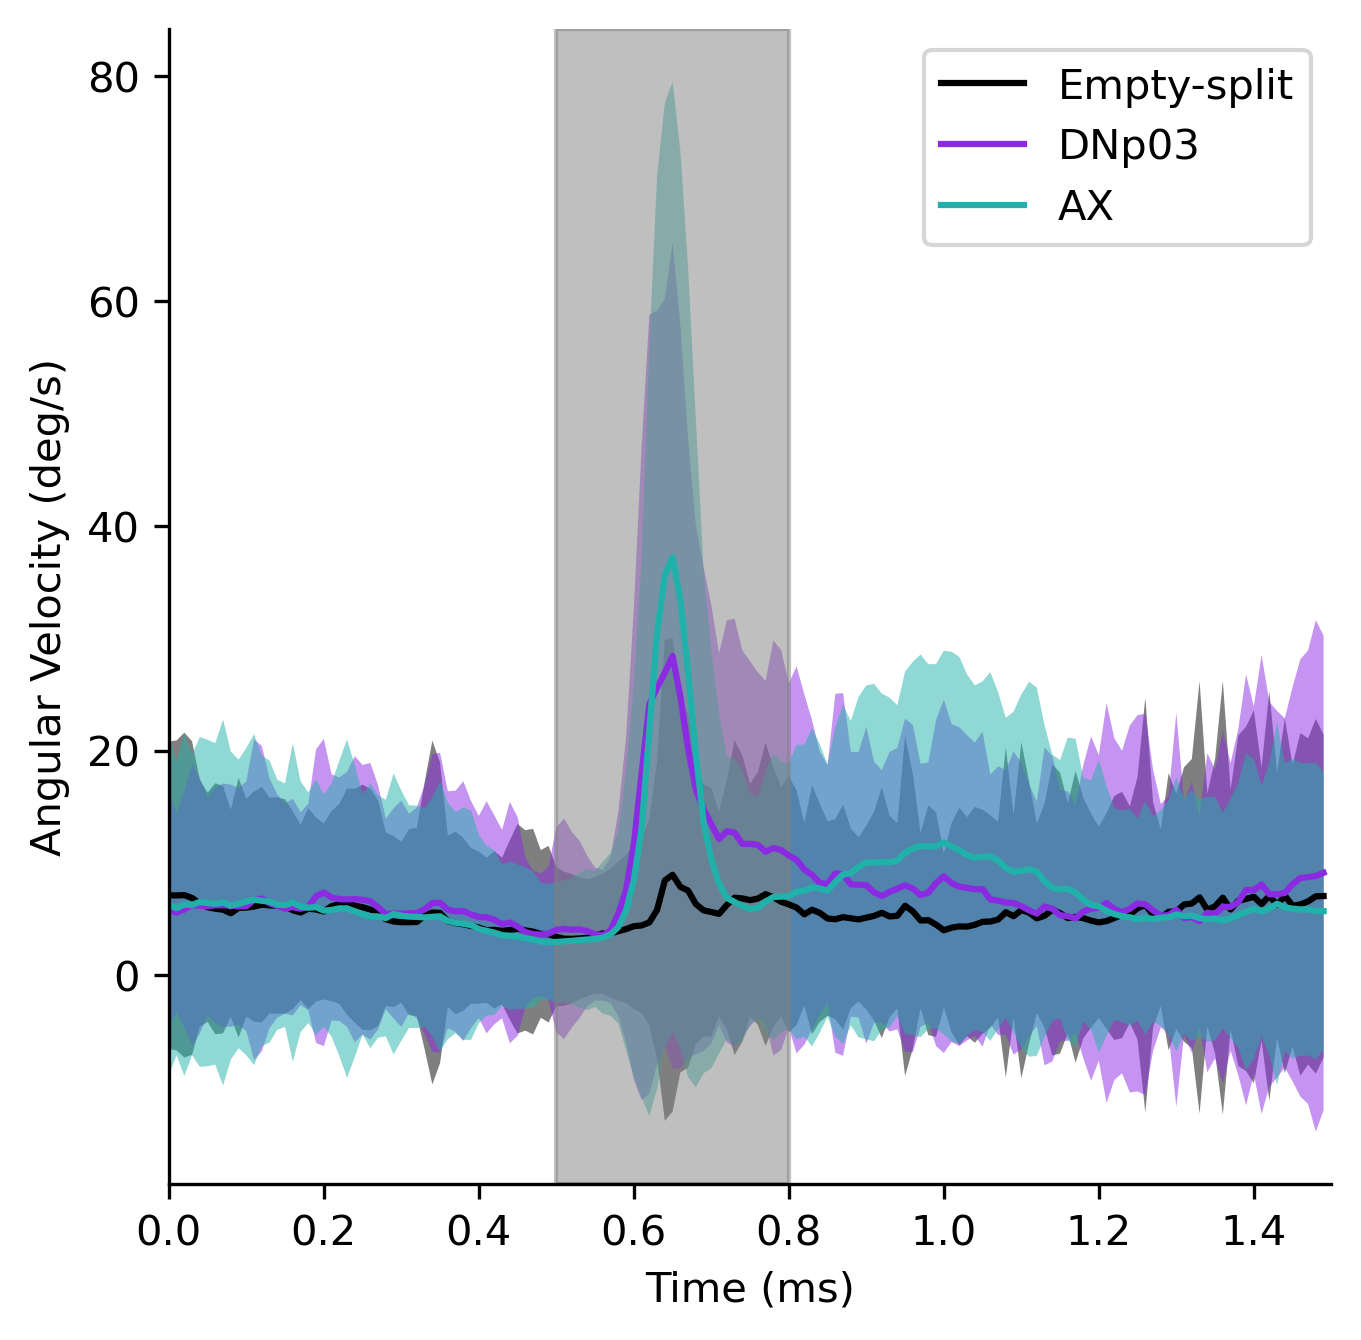

In [28]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

plot_with_mean_and_std(
    empty_data["angular_velocity"],
    label="Empty-split",
    units="milliseconds",
    xlabel="Time (ms)",
    ylabel="Angular Velocity (deg/s)",
    color="#000000",
    ax=ax,
)
plot_with_mean_and_std(
    j53_data["angular_velocity"],
    label="DNp03",
    units="milliseconds",
    color="#8A2BE2",
    ax=ax,
)
plot_with_mean_and_std(
    g29_data["angular_velocity"],
    label="AX",
    units="milliseconds",
    color="#20B2AA",
    ax=ax,
)

# add shaded area between 0.5 and 0.8
plt.axvspan(0.5, 0.8, color="gray", alpha=0.5, edgecolor=None)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlim(0, 1.5)

figname = "2_angular_velocity"

# create folder, skip if exists
os.makedirs(figure_save_folder, exist_ok=True)

plt.savefig(figure_save_folder + figname + ".pdf", dpi=300)
plt.savefig(figure_save_folder + figname + ".svg", dpi=300)

### Heading histogram

In [15]:
# calculate heading change and format for seaborn plotting

heading_change_empty, _ = calculate_heading_amplitude(empty_data["xyz"])
heading_change_j53, _ = calculate_heading_amplitude(j53_data["xyz"])
heading_change_g29, _ = calculate_heading_amplitude(g29_data["xyz"])

heading_change_empty_labels = np.repeat("Empty-split", len(heading_change_empty))
heading_change_j53_labels = np.repeat("DNp03", len(heading_change_j53))
heading_change_g29_labels = np.repeat("AX", len(heading_change_g29))

# create df
heading_change_df = pd.DataFrame(
    {
        "heading_change": np.concatenate(
            [heading_change_empty, heading_change_j53, heading_change_g29]
        ),
        "group": np.concatenate(
            [
                heading_change_empty_labels,
                heading_change_j53_labels,
                heading_change_g29_labels,
            ]
        ),
    }
)

NameError: name 'empty_data' is not defined

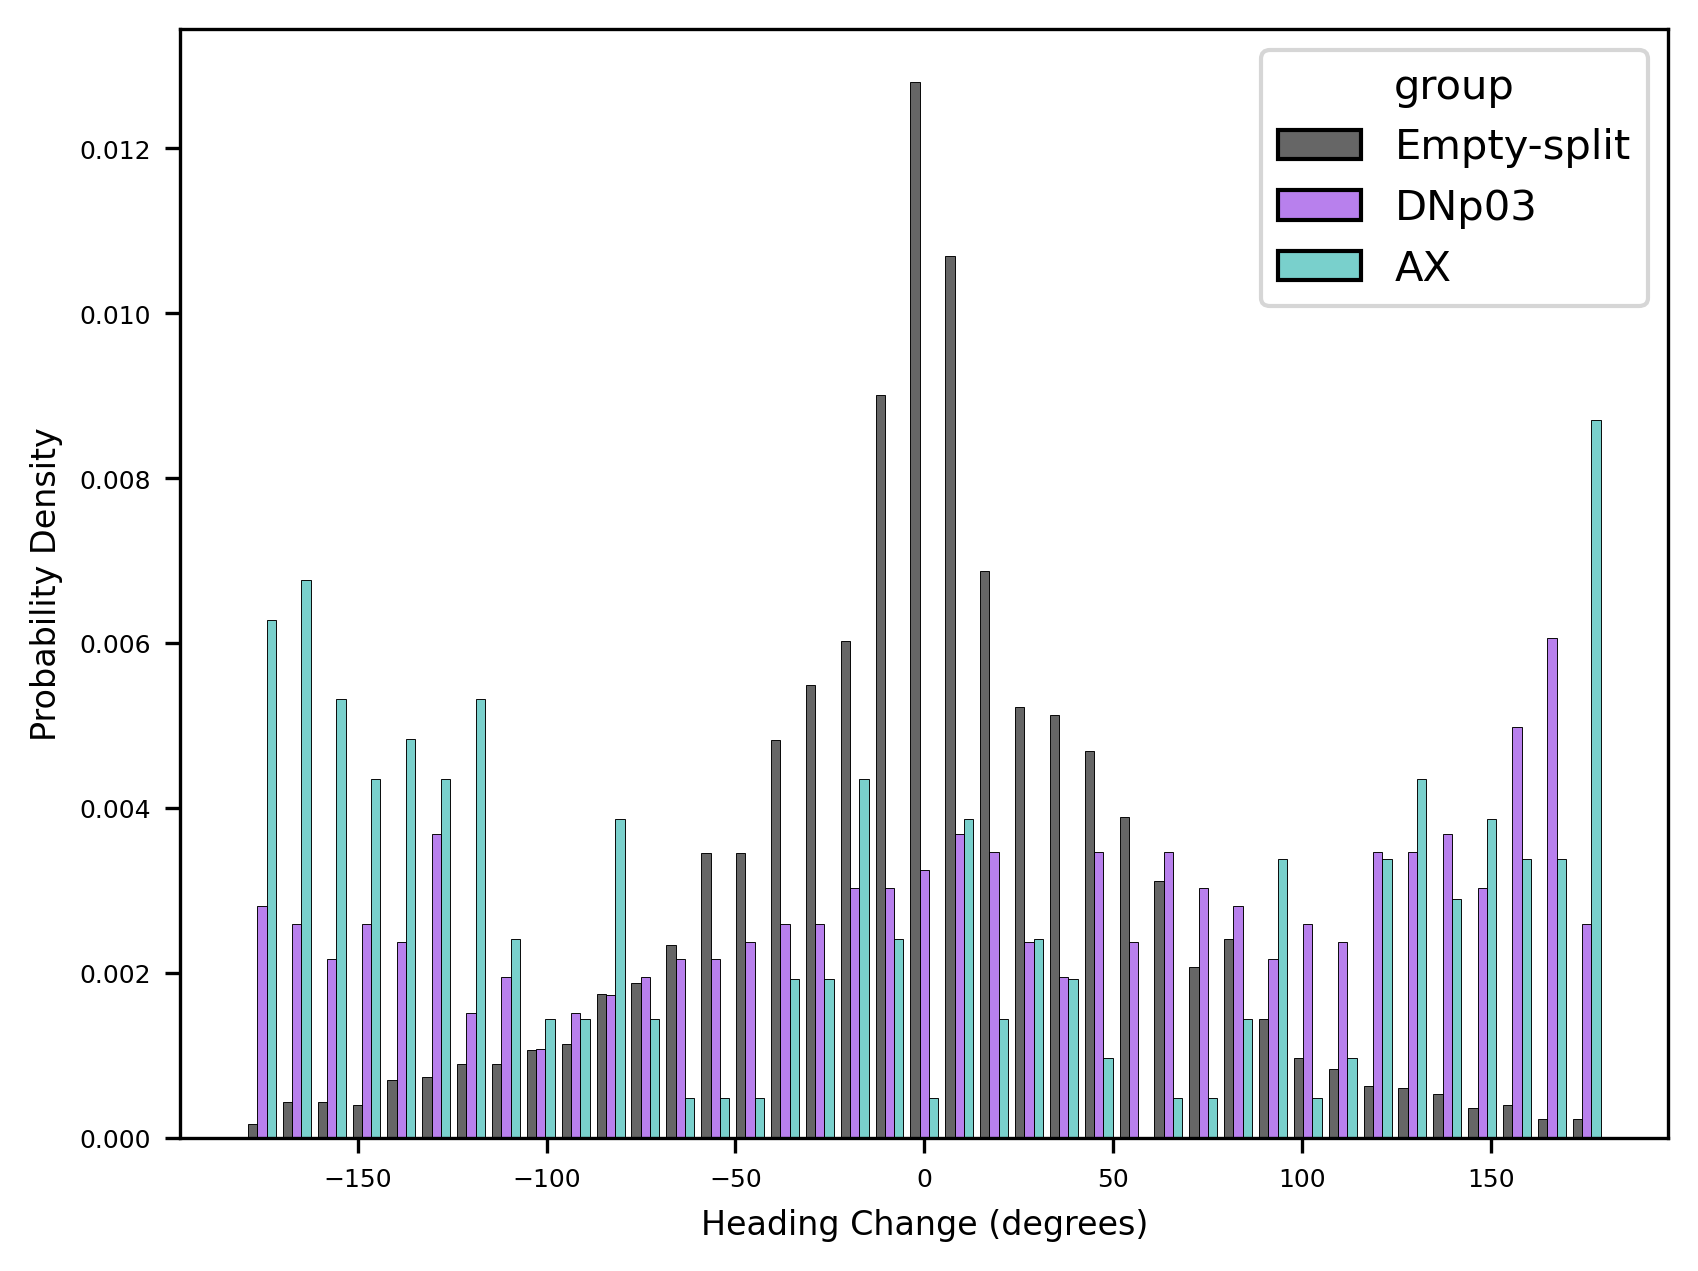

In [18]:
plt.figure(dpi=300)

# Create the histogram
histplot = sns.histplot(
    data=heading_change_df,
    x="heading_change",
    hue="group",
    multiple="dodge",
    stat="density",  # Use density instead of count
    palette=["#000000", "#8A2BE2", "#20B2AA"],
    binrange=(-180, 180),
    common_norm=False,  # Normalize each distribution separately
    alpha=0.6,
    shrink=0.8,  # Shrink the bars to create more space between groups
)

plt.xlabel("Heading Change (degrees)", fontsize=8)
plt.ylabel("Probability Density", fontsize=8)
plt.tick_params(axis="both", which="major", labelsize=6)

# Add a legend with correct labels and adjusted font size
fig.legend(["Empty-Split", "DNp03", "AX"], title="Group", title_fontsize=6, fontsize=4)

figname = "3_direction_histogram"

# create folder, skip if exists
os.makedirs(figure_save_folder, exist_ok=True)

plt.savefig(figure_save_folder + figname + ".pdf", dpi=300)
plt.savefig(figure_save_folder + figname + ".svg", dpi=300)